# Efficient Computation Of Option Greeks Using Malliavin Calculus
Pablo Marchesi 

April 2025

pablomarchesiselma@gmail.com 

https://www.linkedin.com/in/pablo-marchesi-010383199/

In [1]:
import numpy as np            
from scipy.sparse import diags
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(2025)

## Finite Difference Implicit Method

In [2]:
# Terminal Condition
def Utmax(t,x,param):
    sigma, T, K, r = param
    return np.maximum(x-K,0)

# Boundary Conditions
def ULmax(t,tmax,x,param):
    sigma, T, K, r = param
    return x-K*np.exp(-r*(tmax-t))

def ULmin(t,tmax,x,param): 
    sigma, T, K, r = param    
    return Utmax(t,x,param)*np.exp(-r*(tmax-t))

# Coefficients
def coef_a(t,x,param):
    sigma, T, K, r = param
    a = 0.5*sigma**2*x**2
    return a

def coef_b(t,x,param):
    sigma, T, K, r = param
    b = r*x
    return b

def coef_c(t,x,param):
    sigma, T, K, r = param
    c = -r
    return c


In [3]:
# Finite Difference 
def implicit_method(Lmin,Lmax,m,tmin,tmax,n,param):
    
    # Grid
    x_mesh = np.linspace(Lmin,Lmax,m)
    t_mesh = np.linspace(tmin,tmax,n)
    dt = t_mesh[1]-t_mesh[0]
    dx = x_mesh[1]-x_mesh[0]
    alpha = dt/dx**2
    rho = dt/dx
    
    U = np.zeros([n,m])

    # Boundary and terminal conditions
    for j in range(0,m):
        U[n-1,j] = Utmax(tmax,x_mesh[j],param)
    for i in range(0,n):
        U[i,0] = ULmin(t_mesh[i],tmax,Lmin,param)
        U[i,m-1] = ULmax(t_mesh[i],tmax,Lmax,param)
    
    # Coefficients
    atx = np.zeros([m-2,])
    btx = np.zeros([m-2,])
    ctx = np.zeros([m-2,])
    
    for i in range(n-2,-1,-1): 
        
        for j in range(0,m-2):
            atx[j] = coef_a(t_mesh[i],x_mesh[j+1],param)
            btx[j] = coef_b(t_mesh[i],x_mesh[j+1],param)
            ctx[j] = coef_c(t_mesh[i],x_mesh[j+1],param)
  
        # M Matrix 
        dl = -alpha*atx[1:]+rho/2*btx[1:]
        d = 1+2*alpha*atx[:]-dt*ctx[:]
        du = -alpha*atx[:-1]-rho/2*btx[:-1]

        M = diags([dl,d,du],[-1,0,1],shape=(m-2,m-2)).toarray()
        
        # b Matrix  
        b = U[i+1,1:-1].copy()
        
        b[0] += (alpha*atx[0]*U[i,0]-rho*0.5*btx[0]*U[i,0])               
        b[-1] += (alpha*atx[-1]*U[i,m-1]+rho*0.5*btx[-1]*U[i,m-1]) 
        
        aux = np.linalg.solve(M,b)
        
        U[i,1:-1] = aux.T 

    return U,x_mesh,t_mesh,alpha

## Vanilla Option

### European Call Option

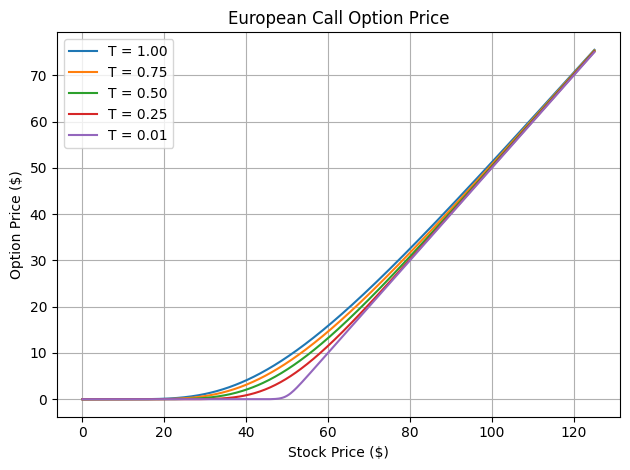

In [4]:
# Parameters and execution
sigma = 0.45; T = 1; K = 50; r = 0.01
param = sigma, T, K, r

m, n = 500, 400
Lmin, Lmax, tmin, tmax = 0.1, 2.5*K, 0, T
Usol, x_mesh, t_mesh, alpha = implicit_method(Lmin,Lmax,m,tmin,tmax,n,param)

timestamps = [0, int(n*0.25), int(n*0.5), int(n*0.75), int(n*0.99)]

for idx in timestamps:
    t_value = t_mesh[idx]
    option_prices = Usol[idx, :]
    plt.plot(x_mesh, option_prices, label=f'T = {T - t_value:.2f}')

plt.title('European Call Option Price')
plt.xlabel('Stock Price ($)')
plt.ylabel('Option Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### Delta

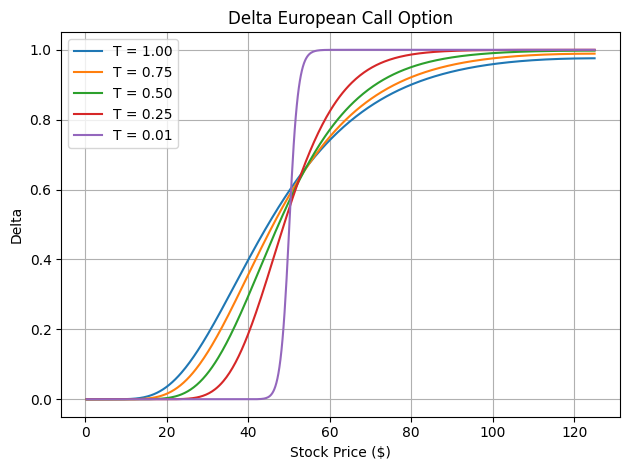

In [5]:
# Delta 
UdeltaSol = np.zeros_like(Usol[1:,:])
h = x_mesh[1] - x_mesh[0]
UdeltaSol = (Usol[:,1:] - Usol[:,0:-1])/h
x_mesh_delta = x_mesh[1:]

for idx in timestamps:
    t_value = t_mesh[idx]
    option_prices = UdeltaSol[idx, :]
    plt.plot(x_mesh_delta, option_prices, label=f'T = {T - t_value:.2f}')

plt.title('Delta European Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [6]:
def malliavin_delta(S0, param, paths = int(1e6)):
    
    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)
    
    # Option Payoff 
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    payoff = np.maximum(ST - K, 0)
    
    # Malliavin delta weight
    weight = W_T / (S0 * sigma * T)
    delta = np.mean(payoff * weight) * np.exp(-r * T)
    return delta

def blackScholes_delta(S0, param):

    sigma, T, K, r = param
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

def finDif_delta(S0, param, h = 1,  paths = int(1e6)):

    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)

    # Call at S0 + h
    ST_plus = (S0 + h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_plus = np.mean(np.maximum(ST_plus - K, 0))*np.exp(-r * T)

    # Call at S0 - h
    ST_minus = (S0 - h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_minus = np.mean(np.maximum(ST_minus - K, 0))*np.exp(-r * T)

    # Delta finnite difference
    delta = (C_plus - C_minus) / (2 * h)
    return delta

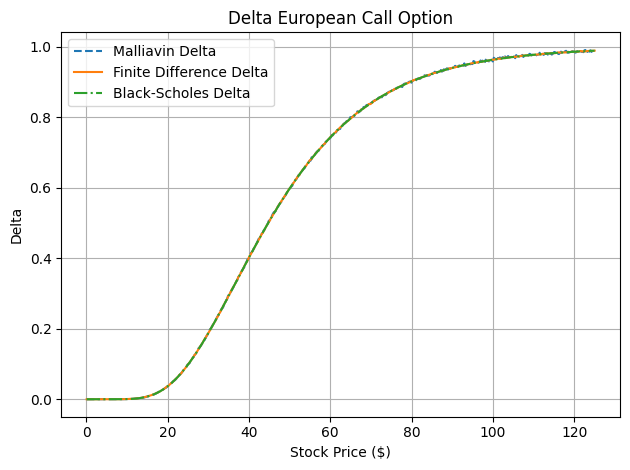

In [7]:
# Malliavin vs Black-Scholes vs Finite Difference
mv_delta = [malliavin_delta(S0, param) for S0 in x_mesh]
bs_delta = [blackScholes_delta(S0, param) for S0 in x_mesh]
mc_delta = [finDif_delta(S0, param) for S0 in x_mesh]

plt.plot(x_mesh, mv_delta, label='Malliavin Delta', linestyle='--')
plt.plot(x_mesh, mc_delta, label='Finite Difference Delta', linestyle='-')
plt.plot(x_mesh, bs_delta, label='Black-Scholes Delta', linestyle='-.')

plt.title('Delta European Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gamma

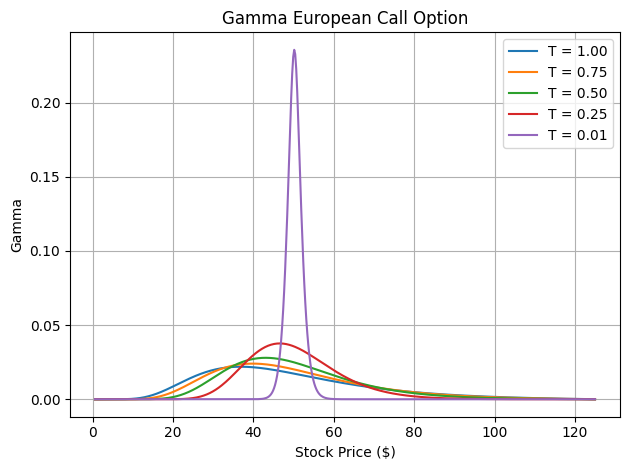

In [8]:
# Gamma
UgammaSol = np.zeros_like(UdeltaSol[1:,:])
h = x_mesh_delta[1] - x_mesh_delta[0]
UgammaSol = (UdeltaSol[:,1:] - UdeltaSol[:,0:-1])/h
x_mesh_gamma = x_mesh_delta[1:]

for idx in timestamps:
    t_value = t_mesh[idx]
    option_prices = UgammaSol[idx, :]
    plt.plot(x_mesh_gamma, option_prices, label=f'T = {T - t_value:.2f}')

plt.title('Gamma European Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [9]:
def malliavin_gamma(S0, param, paths = int(1e6)):
    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)
    
    # Option Payoff 
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    payoff = np.maximum(ST - K, 0)

    # Malliavin gamma weight
    weight = (W_T**2 - T - W_T*sigma*T) / (S0*sigma*T)**2
    gamma = np.mean(payoff * weight) * np.exp(-r * T)
    return gamma


def blackScholes_gamma(S0, param):
    sigma, T, K, r = param
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
    return gamma


def finDif_gamma(S0, param, h = 1, paths = int(1e6)):
    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)

    # Call at S0 + h
    ST_plus = (S0 + h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_plus = np.mean(np.maximum(ST_plus - K, 0)) * np.exp(-r * T)

    # Call at S0
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C = np.mean(np.maximum(ST - K, 0)) * np.exp(-r * T)

    # Call at S0 - h
    ST_minus = (S0 - h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_minus = np.mean(np.maximum(ST_minus - K, 0)) * np.exp(-r * T)

    # Gamma finite difference
    gamma = (C_plus - 2 * C + C_minus) / (h ** 2)
    return gamma

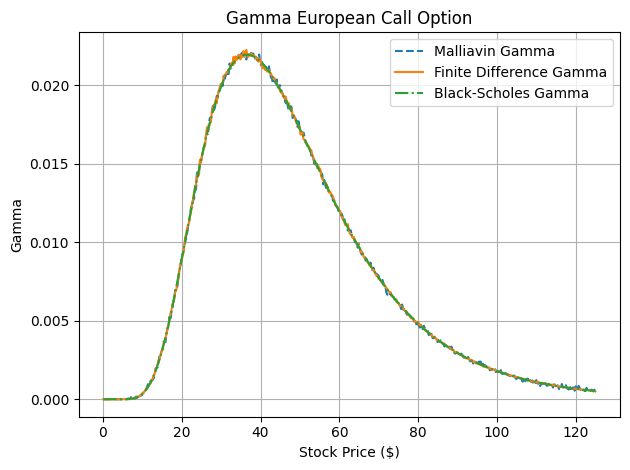

In [10]:
# Malliavin vs Black-Scholes vs Finite Difference
mv_gamma = [malliavin_gamma(S0, param) for S0 in x_mesh]
bs_gamma = [blackScholes_gamma(S0, param) for S0 in x_mesh]
mc_gamma = [finDif_gamma(S0, param) for S0 in x_mesh]

plt.plot(x_mesh, mv_gamma, label='Malliavin Gamma', linestyle='--')
plt.plot(x_mesh, mc_gamma, label='Finite Difference Gamma', linestyle='-')
plt.plot(x_mesh, bs_gamma, label='Black-Scholes Gamma', linestyle='-.')

plt.title('Gamma European Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Exotic Option

### Digital Call

In [11]:
# Terminal Condition
def Utmax(t,x,param):
    sigma, T, K, r = param
    return 1 if (x > K) else 0

# Boundary Conditions
def ULmax(t,tmax,x,param):
    sigma, T, K, r = param
    return Utmax(t,x,param)*np.exp(-r*(tmax-t))

def ULmin(t,tmax,x,param): 
    sigma, T, K, r = param    
    return Utmax(t,x,param)*np.exp(-r*(tmax-t))

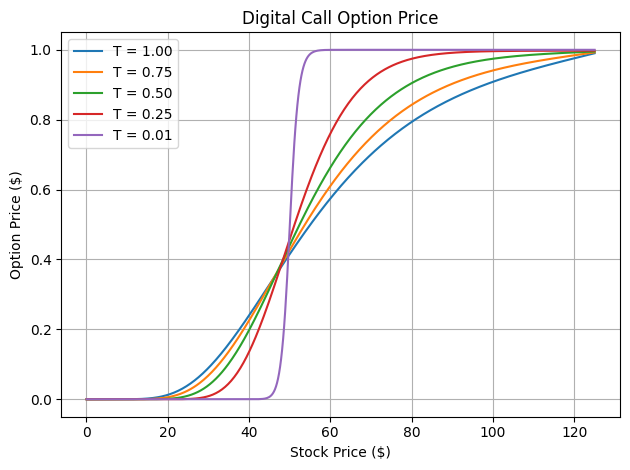

In [12]:
# Execution
Usol, x_mesh, t_mesh, alpha = implicit_method(Lmin,Lmax,m,tmin,tmax,n,param)

for idx in timestamps:
    t_value = t_mesh[idx]
    option_prices = Usol[idx, :]
    plt.plot(x_mesh, option_prices, label=f'T = {T - t_value:.2f}')

plt.title('Digital Call Option Price')
plt.xlabel('Stock Price ($)')
plt.ylabel('Option Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### Delta

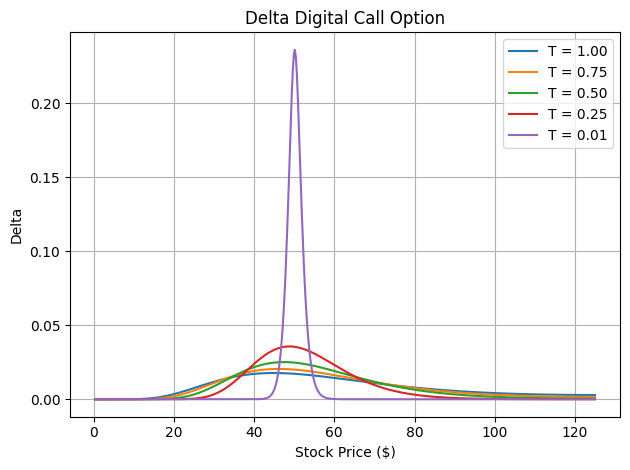

In [13]:
# Delta 
UdeltaSol = np.zeros_like(Usol[1:,:])
h = x_mesh[1] - x_mesh[0]
UdeltaSol = (Usol[:,1:] - Usol[:,0:-1])/h
x_mesh_delta = x_mesh[1:]

for idx in timestamps:
    t_value = t_mesh[idx]
    option_prices = UdeltaSol[idx, :]
    plt.plot(x_mesh_delta, option_prices, label=f'T = {T - t_value:.2f}')

plt.title('Delta Digital Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [14]:
def malliavin_delta_digi(S0, param, paths = int(1e6)):
    
    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)
    
    # Option Payoff 
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    payoff = (ST > K).astype(float)
    
    # Malliavin delta weight
    weight = W_T / (S0 * sigma * T)
    delta = np.mean(payoff * weight) * np.exp(-r * T)
    return delta

def blackScholes_delta_digi(S0, param):

    sigma, T, K, r = param
    d1 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = np.exp(-r*T)*norm.pdf(d1)/(S0*sigma*np.sqrt(T))
    return delta

def finDif_delta_digi(S0, param, h = 1,  paths = int(1e6)):

    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)

    # Call at S0 + h
    ST_plus = (S0 + h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_plus = np.mean(ST_plus > K)*np.exp(-r * T)

    # Call at S0 - h
    ST_minus = (S0 - h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_minus = np.mean(ST_minus > K)*np.exp(-r * T)

    # Delta finnite difference
    delta = (C_plus - C_minus) / (2 * h)
    return delta

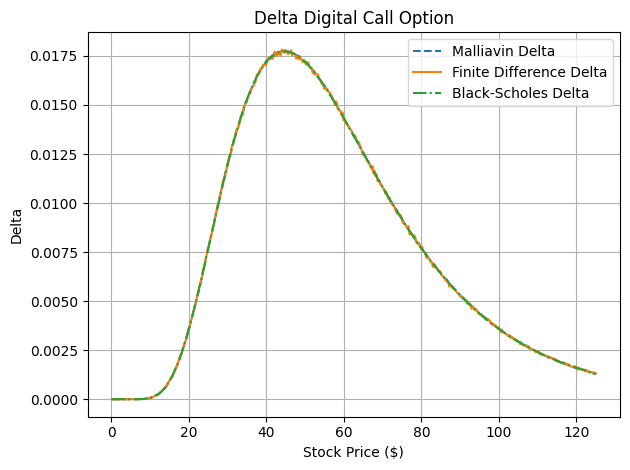

In [15]:
# Malliavin vs Black-Scholes vs Finite Difference vs Finite Difference
mv_delta = [malliavin_delta_digi(S0, param) for S0 in x_mesh]
bs_delta = [blackScholes_delta_digi(S0, param) for S0 in x_mesh]
mc_delta = [finDif_delta_digi(S0, param) for S0 in x_mesh]

plt.plot(x_mesh, mv_delta, label='Malliavin Delta', linestyle='--')
plt.plot(x_mesh, mc_delta, label='Finite Difference Delta', linestyle='-')
plt.plot(x_mesh, bs_delta, label='Black-Scholes Delta', linestyle='-.')

plt.title('Delta Digital Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gamma

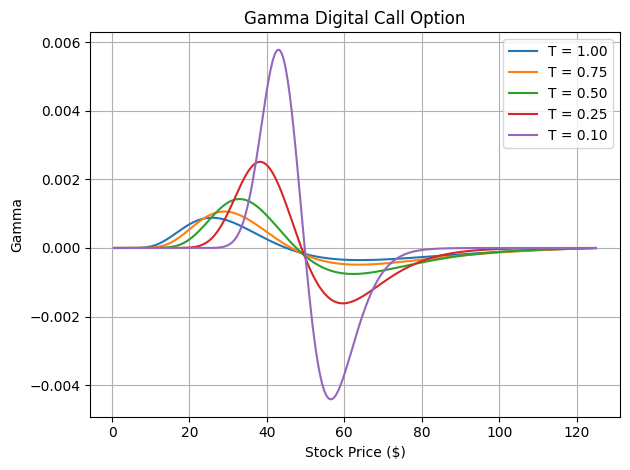

In [16]:
# Gamma
UgammaSol = np.zeros_like(UdeltaSol[1:,:])
h = x_mesh_delta[1] - x_mesh_delta[0]
UgammaSol = (UdeltaSol[:,1:] - UdeltaSol[:,0:-1])/h
x_mesh_gamma = x_mesh_delta[1:]

timestamps = [0, int(n*0.25), int(n*0.5), int(n*0.75), int(n*0.9)]

for idx in timestamps:
    t_value = t_mesh[idx]
    option_prices = UgammaSol[idx, :]
    plt.plot(x_mesh_gamma, option_prices, label=f'T = {T - t_value:.2f}')

plt.title('Gamma Digital Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [17]:
def malliavin_gamma_digi(S0, param, paths = int(1e6)):
    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)

    # Terminal asset price
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    payoff = (ST > K).astype(float)

    # Malliavin gamma weight for digital
    weight = (W_T**2 - T - W_T*sigma*T) / (S0*sigma*T)**2
    gamma = np.mean(payoff * weight) * np.exp(-r * T)
    return gamma


def blackScholes_gamma_digi(S0, param):
    sigma, T, K, r = param
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = -np.exp(-r*T)*norm.pdf(d2)*(sigma*np.sqrt(T)+d2)/(S0*sigma*np.sqrt(T))**2
    return gamma


def finDif_gamma_digi(S0, param, h = 5, paths = int(1e6)):
    sigma, T, K, r = param

    # Brownian Motion at t = T
    W_T = np.random.normal(0, np.sqrt(T), paths)

    # Call at S0 + h
    ST_plus = (S0 + h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_plus = np.mean(ST_plus > K) * np.exp(-r * T)

    # Call at S0
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C = np.mean(ST > K) * np.exp(-r * T)

    # Call at S0 - h
    ST_minus = (S0 - h) * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    C_minus = np.mean(ST_minus > K) * np.exp(-r * T)

    # Gamma finite difference
    gamma = (C_plus - 2 * C + C_minus) / (h ** 2)
    return gamma

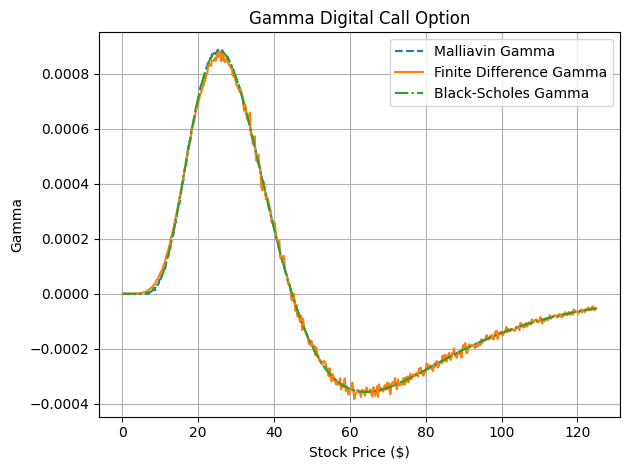

In [18]:
# Malliavin vs Black-Scholes vs Finite Difference
mv_gamma = [malliavin_gamma_digi(S0, param) for S0 in x_mesh]
bs_gamma = [blackScholes_gamma_digi(S0, param) for S0 in x_mesh]
mc_gamma = [finDif_gamma_digi(S0, param) for S0 in x_mesh]

plt.plot(x_mesh, mv_gamma, label='Malliavin Gamma', linestyle='--')
plt.plot(x_mesh, mc_gamma, label='Finite Difference Gamma', linestyle='-')
plt.plot(x_mesh, bs_gamma, label='Black-Scholes Gamma', linestyle='-.')

plt.title('Gamma Digital Call Option')
plt.xlabel('Stock Price ($)')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Precission Test

### Delta European Call

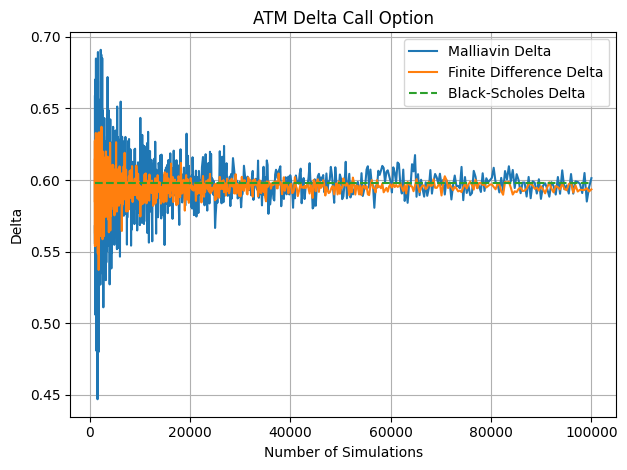

In [19]:
S0 = K; h = 5
exp_range = np.logspace(3, 5, 1000, dtype=int)
mv_delta = [malliavin_delta(S0, param, i) for i in exp_range]
mc_delta = [finDif_delta(S0, param, h, i) for i in exp_range]
bs_delta = [blackScholes_delta(S0, param)]*len(exp_range)

plt.plot(exp_range, mv_delta, label='Malliavin Delta', linestyle='-')
plt.plot(exp_range, mc_delta, label='Finite Difference Delta', linestyle='-')
plt.plot(exp_range, bs_delta, label='Black-Scholes Delta', linestyle='--')

plt.title('ATM Delta Call Option')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gamma European Call

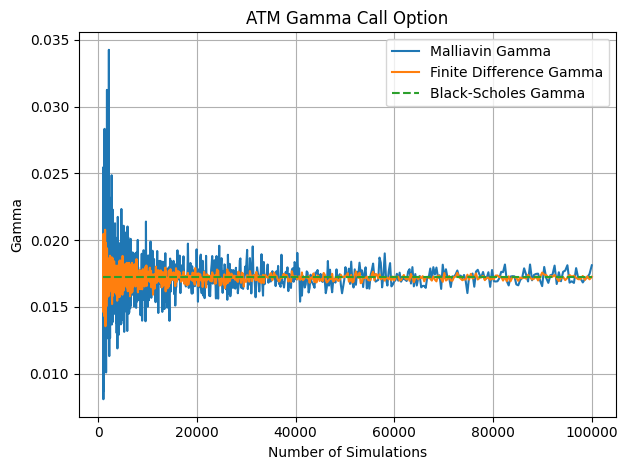

In [20]:
S0 = K; h = 5
exp_range = np.logspace(3, 5, 1000, dtype=int)
mv_gamma = [malliavin_gamma(S0, param, i) for i in exp_range]
mc_gamma = [finDif_gamma(S0, param, h, i) for i in exp_range]
bs_gamma = [blackScholes_gamma(S0, param)]*len(exp_range)

plt.plot(exp_range, mv_gamma, label='Malliavin Gamma', linestyle='-')
plt.plot(exp_range, mc_gamma, label='Finite Difference Gamma', linestyle='-')
plt.plot(exp_range, bs_gamma, label='Black-Scholes Gamma', linestyle='--')

plt.title('ATM Gamma Call Option')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Delta Digital Call

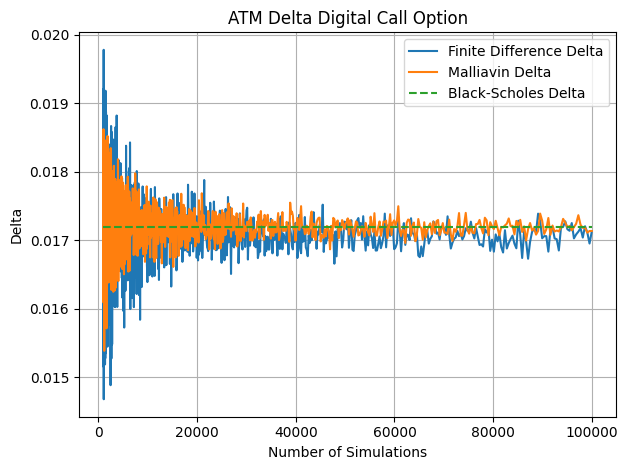

In [21]:
S0 = K; h = 5
exp_range = np.logspace(3, 5, 1000, dtype=int)
mv_delta = [malliavin_delta_digi(S0, param, i) for i in exp_range]
mc_delta = [finDif_delta_digi(S0, param, h, i) for i in exp_range]
bs_delta = [blackScholes_delta_digi(S0, param)]*len(exp_range)

plt.plot(exp_range, mc_delta, label='Finite Difference Delta', linestyle='-')
plt.plot(exp_range, mv_delta, label='Malliavin Delta', linestyle='-')
plt.plot(exp_range, bs_delta, label='Black-Scholes Delta', linestyle='--')

plt.title('ATM Delta Digital Call Option')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gamma Digital Call

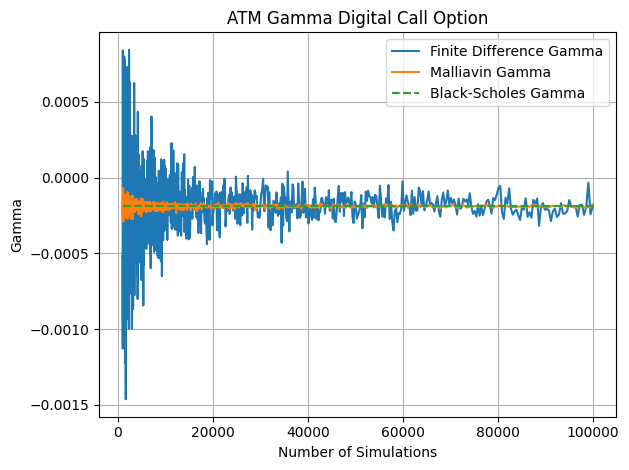

In [22]:
S0 = K; h = 5
exp_range = np.logspace(3, 5, 1000, dtype=int)
mv_gamma = [malliavin_gamma_digi(S0, param, i) for i in exp_range]
mc_gamma = [finDif_gamma_digi(S0, param, h, i) for i in exp_range]
bs_gamma = [blackScholes_gamma_digi(S0, param)]*len(exp_range)

plt.plot(exp_range, mc_gamma, label='Finite Difference Gamma', linestyle='-')
plt.plot(exp_range, mv_gamma, label='Malliavin Gamma', linestyle='-')
plt.plot(exp_range, bs_gamma, label='Black-Scholes Gamma', linestyle='--')

plt.title('ATM Gamma Digital Call Option')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()